In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Dropout, Dense, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l1, l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.stats import skew, bernoulli
from bitstring import BitArray
from deap import base, creator, tools, algorithms

In [23]:
df = pd.read_csv("Airpollutiondata.csv")
#print(df.head())
# Make single variable
#df.drop(['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df = df.set_index(['date'], drop=True)

print(df.tail())

                     Caidian  Huangpi  Wuhan  Xinzhou  Xianning
date                                                           
2019-03-15 03:00:00     53.0     57.7   56.4     53.2      34.5
2019-03-15 04:00:00     47.9     54.3   54.4     52.8      37.6
2019-03-15 05:00:00     42.9     51.9   47.8     51.2      36.6
2019-03-15 06:00:00     34.9     40.9   35.8     46.3      37.1
2019-03-15 07:00:00     33.9     37.8   35.2     42.8      33.9


In [24]:
#Converts dataframe to array
data = df.to_numpy()
print(data.shape)
#Split into training and test data
data_length = len(data)
train_split = 0.9
train_length = int(train_split * data_length)
test_length = data_length - train_length

x_train = data[0:train_length, :]
x_test = data[train_length:, :]

y_train = data[0:train_length, -1]
y_test = data[train_length:, -1]



(40390, 5)


In [25]:
x_scaler = MinMaxScaler((0,1))
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler((0,1))
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1,1))

print(x_train_scaled.shape)

(36351, 5)


In [39]:
def LSTMCNNmodel(hidden_size, input_shape):
    
    lstmcnn = Sequential()
    lstmcnn.add(TimeDistributed(Conv1D(filters=12, kernel_size=2, activation='relu'), input_shape=input_shape))
    lstmcnn.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    #lstmcnn.add(TimeDistributed(Conv1D(filters=128, kernel_size=1, activation='relu')))
    #lstmcnn.add(TimeDistributed(MaxPooling1D(pool_size=1)))
    lstmcnn.add(TimeDistributed(Flatten()))
    
    lstmcnn.add(LSTM(hidden_size, activation='relu', return_sequences=True))
    lstmcnn.add(Dropout(0.2))
    lstmcnn.add(Dense(50, activation='relu'))
    lstmcnn.add(Dense(1, activation='linear'))
    lstmcnn.build()
    return lstmcnn

In [40]:
def split_sequence(sequence, n_steps, window_space=1):

    for j in range(sequence.shape[1]):
        
        data_seq = []
        for i in range(0, len(sequence[:, j]), window_space):
            end_index = i + n_steps
            if end_index > sequence.shape[0]-1:
                break
            x = sequence[i:end_index, j]
            data_seq.append(x) 
            
        data_seq = np.array(data_seq)
        data_seq = np.expand_dims(data_seq, axis=2)
    
        if j == 0:
            data = data_seq
        else:
            data = np.concatenate((data, data_seq), axis=2)    
            
    return (data)

In [41]:
def GetLabels(sequence, n_steps, window_space=1):
    
    label_seq = []
    for i in range(0, len(sequence), window_space):
        end_index = i + n_steps
        if end_index > len(sequence)-1:
            break
        labels = sequence[end_index]
        label_seq.append(labels)
    
    label_seq = np.array(label_seq)
    label_seq = label_seq.reshape(len(label_seq),1)
    
    return label_seq

In [42]:
#Hyper-Parameters
window_size = 16
window_space = 1
lstm_size = 1000
learning_rate = 0.0001
epochs = 15
batch_size = 32

#Extract train and test features
train_features = split_sequence(x_train_scaled, window_size, window_space)
test_features = split_sequence(x_test_scaled, window_size, window_space)
train_input, test_input = train_features.reshape((train_features.shape[0], sqrt(window_size), sqrt(window_size), train_features.shape[2])), test_features.reshape((test_features.shape[0], sqrt(window_size), sqrt(window_size), test_features.shape[2]))

input_shape = (None, train_input.shape[2], train_input.shape[3])

#Get train and test labels
train_labels = GetLabels(y_train_scaled, window_size, window_space)
test_labels = GetLabels(y_test_scaled, window_size, window_space)

train_labels, validation_labels = np.expand_dims(train_labels, axis=1), np.expand_dims(test_labels, axis=1)

#Validation Data
validation_data = (test_input, validation_labels)

print(train_input.shape)
print(train_labels.shape)
print(test_input.shape)
print(test_labels.shape)


(36335, 16, 5)
(36335, 4, 4, 5)
(36335, 1, 1)
(4023, 4, 4, 5)
(4023, 1)


In [43]:
def mse(y_true, y_pred):

    loss = tf.reduce_mean(tf.losses.mean_squared_error(labels=y_true, predictions=y_pred))
    return loss

optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate)

model = LSTMCNNmodel(lstm_size, input_shape)

model.compile(loss=mse, 
              optimizer=optimiser,
              metrics=['MAE'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, None, 3, 12)       132       
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 1, 12)       0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 12)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 1000)        4052000   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 1000)        0         
_________________________________________________________________
dense_2 (Dense)              (None, None, 50)          50050     
_________________________________________________________________
dense_3 (Dense)              (None, None, 1)           51        
Total para

In [44]:
history = model.fit(train_input,
                    train_labels,
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_data=validation_data,
                    shuffle=False)

Train on 36335 samples, validate on 4023 samples
Epoch 1/15
36335/36335 [==============================] - 18s 485us/sample - loss: 0.0035 - mean_absolute_error: 0.0382 - val_loss: 0.0019 - val_mean_absolute_error: 0.0300
Epoch 2/15
36335/36335 [==============================] - 16s 437us/sample - loss: 0.0021 - mean_absolute_error: 0.0309 - val_loss: 0.0018 - val_mean_absolute_error: 0.0293
Epoch 3/15
36335/36335 [==============================] - 16s 437us/sample - loss: 0.0020 - mean_absolute_error: 0.0304 - val_loss: 0.0018 - val_mean_absolute_error: 0.0291
Epoch 4/15
36335/36335 [==============================] - 16s 437us/sample - loss: 0.0020 - mean_absolute_error: 0.0301 - val_loss: 0.0018 - val_mean_absolute_error: 0.0289
Epoch 5/15
36335/36335 [==============================] - 16s 437us/sample - loss: 0.0020 - mean_absolute_error: 0.0299 - val_loss: 0.0018 - val_mean_absolute_error: 0.0288
Epoch 6/15
36335/36335 [==============================] - 16s 437us/sample - loss: 0.0

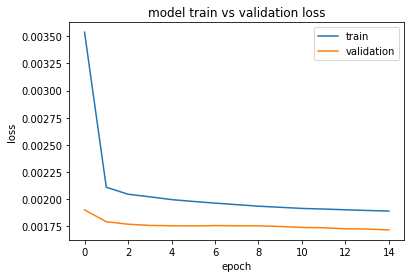

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

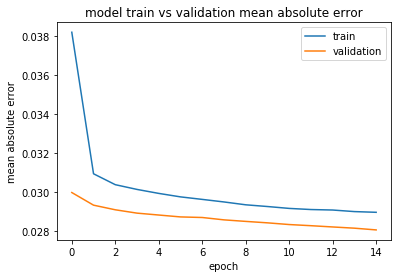

In [46]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model train vs validation mean absolute error')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

(4023, 4, 1)
(4023, 1)
13.546131000397054


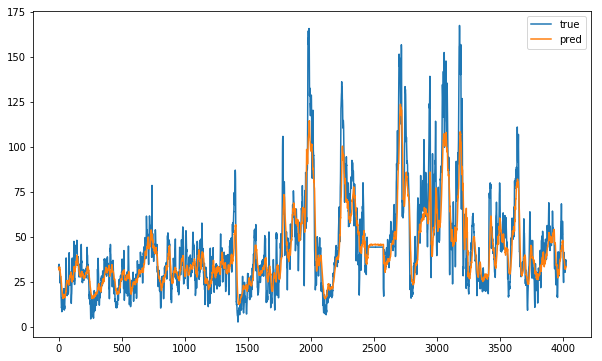

In [51]:
def plot_comparison():
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """

       # Use test-data.
    x = test_input
    y_true = y_scaler.inverse_transform(test_labels)
    
    #x = np.expand_dims(x, axis=1)
    
    
    # Select the sequences from the given start-index and
    # of the given length.
    
    # Input-signals for the model.
    
    
    # Use the model to predict the output-signals.
    x_pred = model.predict(x)    
    
    #x_pred = x_pred.reshape(-1,1)
    print(x_pred.shape)
    x_pred = np.average(x_pred, axis=1)
    y_pred_rescaled = y_scaler.inverse_transform(x_pred)  

    # For each output-signal.
    print(y_pred_rescaled.shape)
    
    rmse = sqrt(mean_squared_error(y_true, y_pred_rescaled))
    print(rmse)
    
    # Make the plotting-canvas bigger.
    plt.figure(figsize=(10,6))
    
    # Plot and compare the two signals.
    plt.plot(y_true, label='true')
    plt.plot(y_pred_rescaled, label='pred')
        
    # Plot labels etc.
    plt.legend()
    plt.show()
    
plot_comparison()